Data inserted successfully at:  2024-05-20T21:55:26


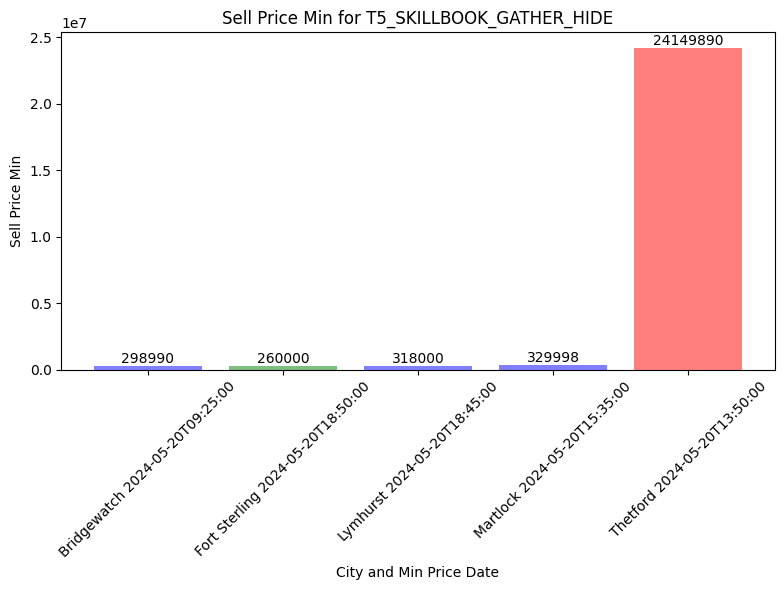

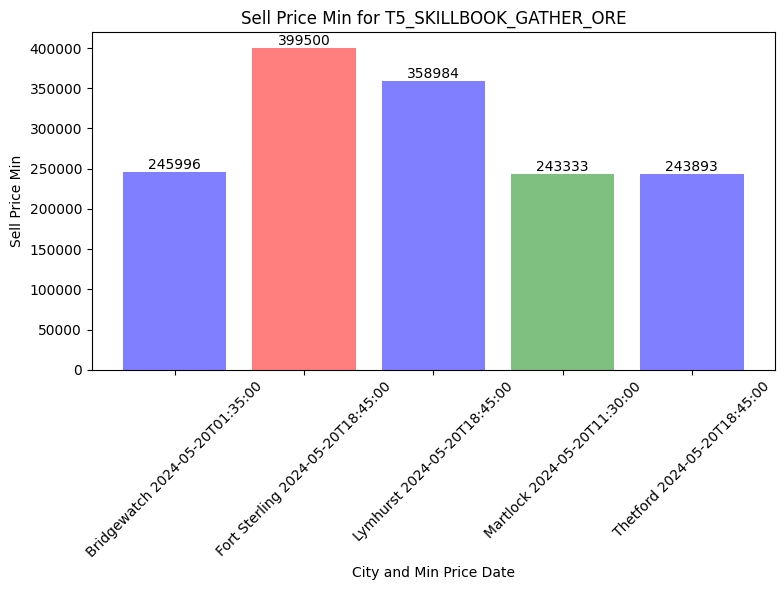

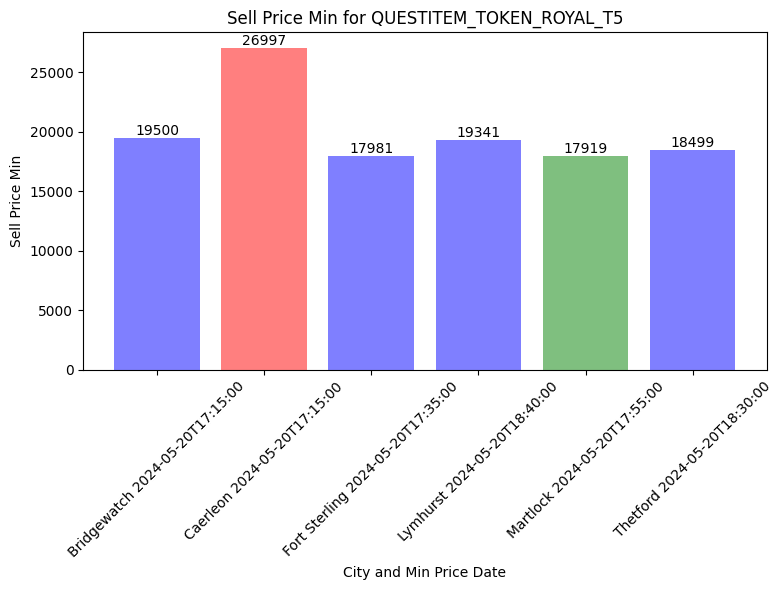

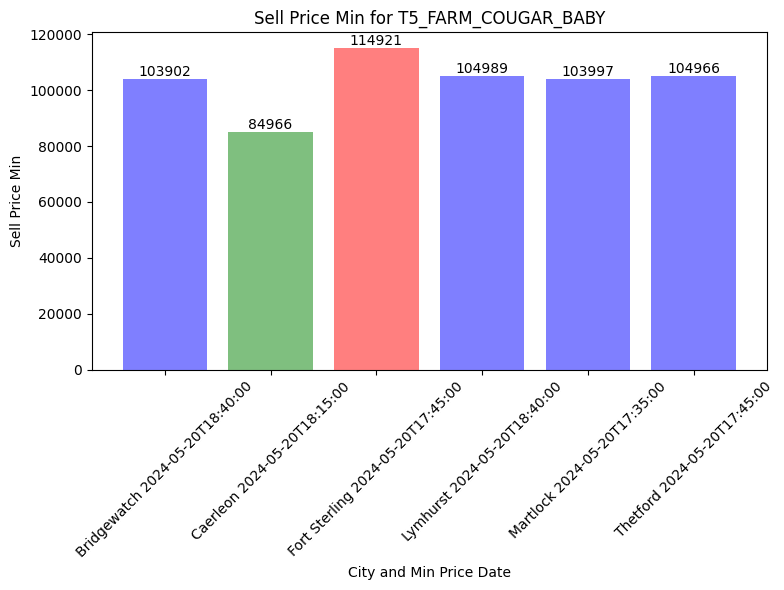

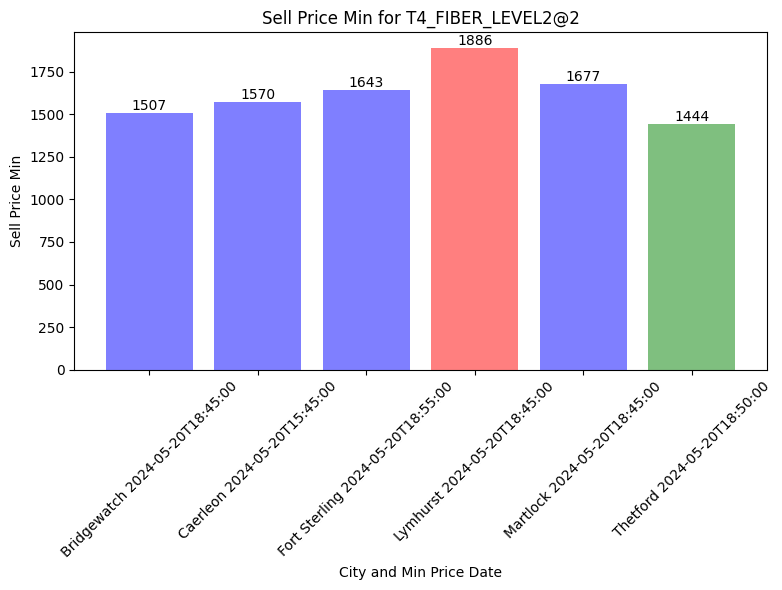

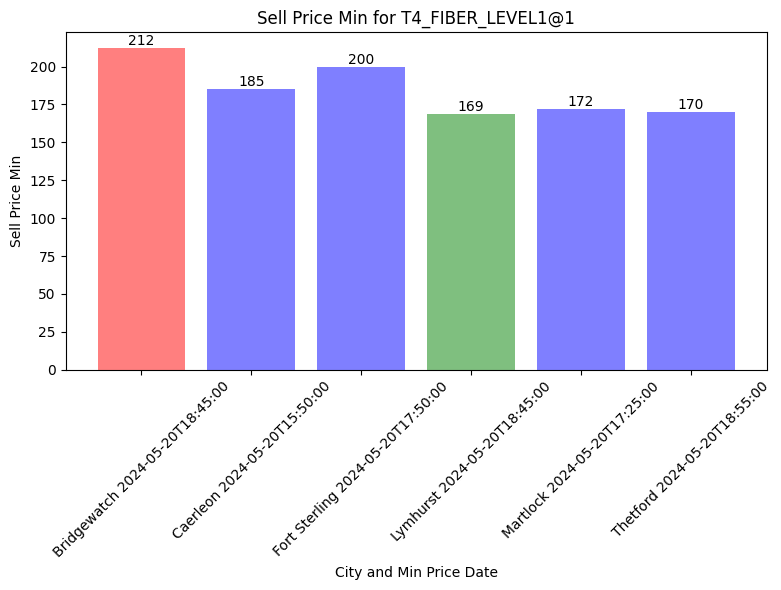

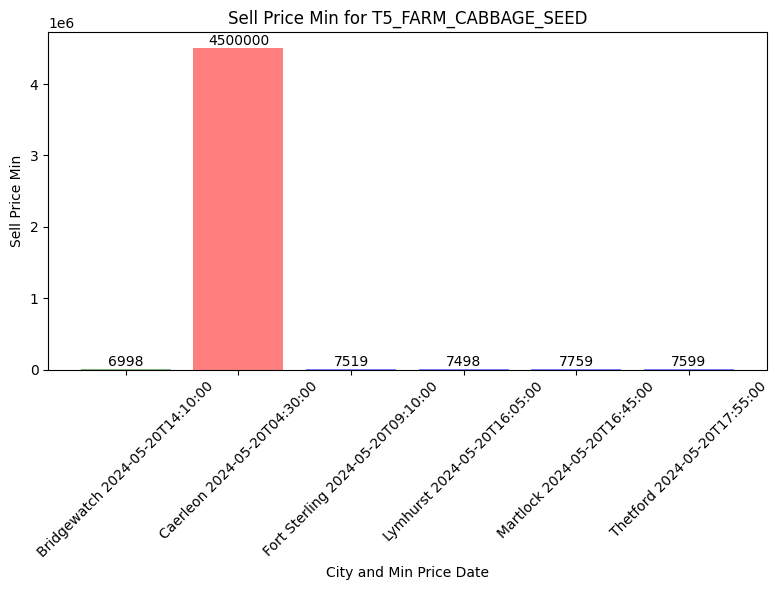

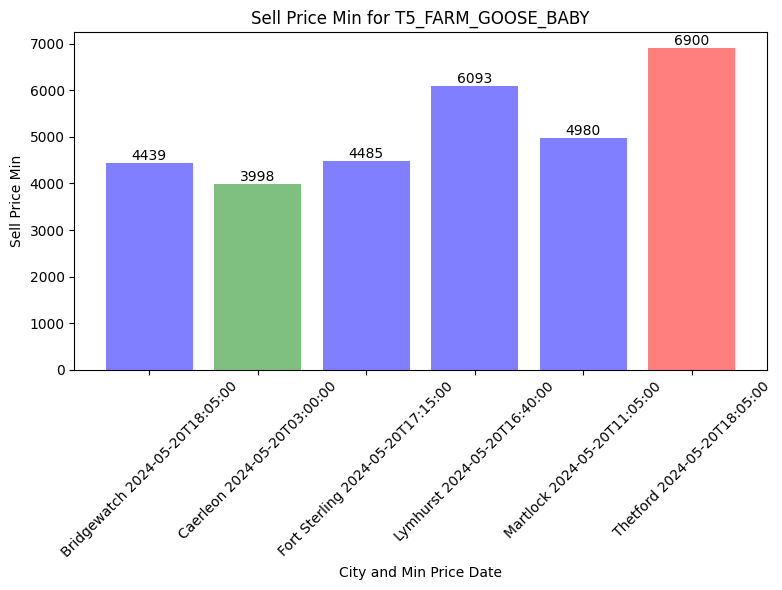

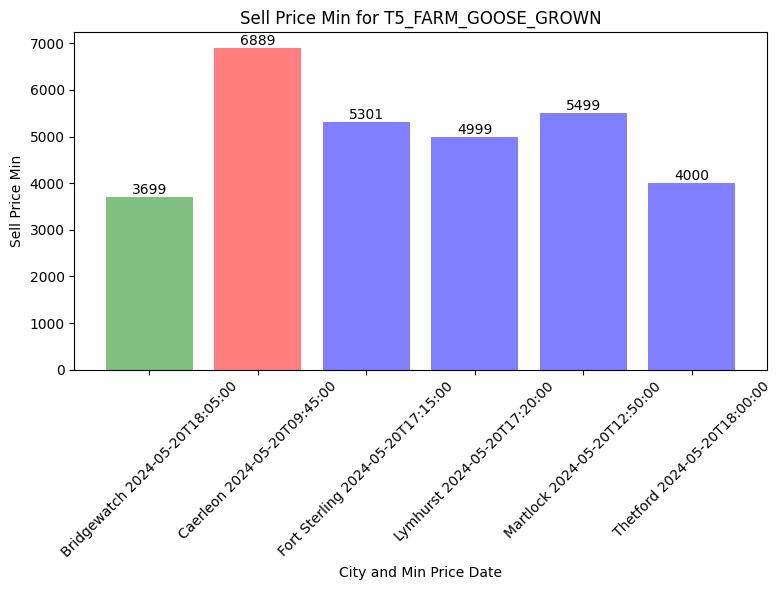

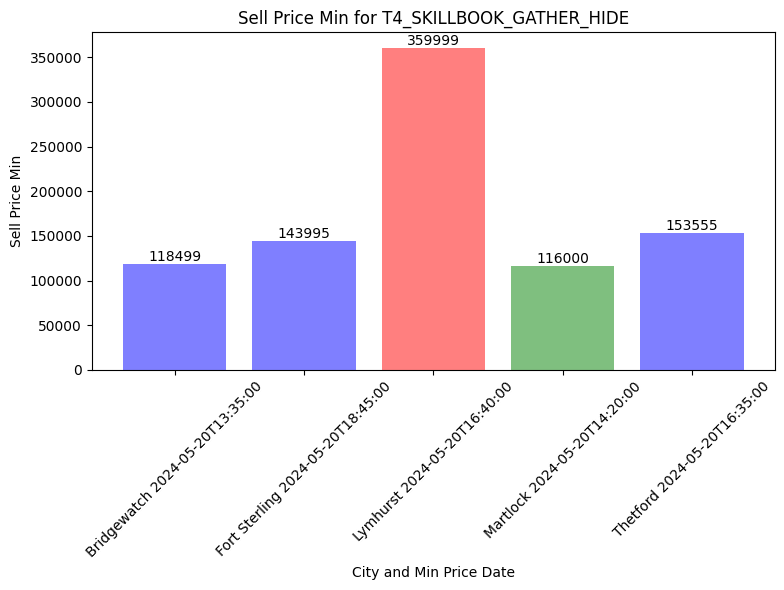

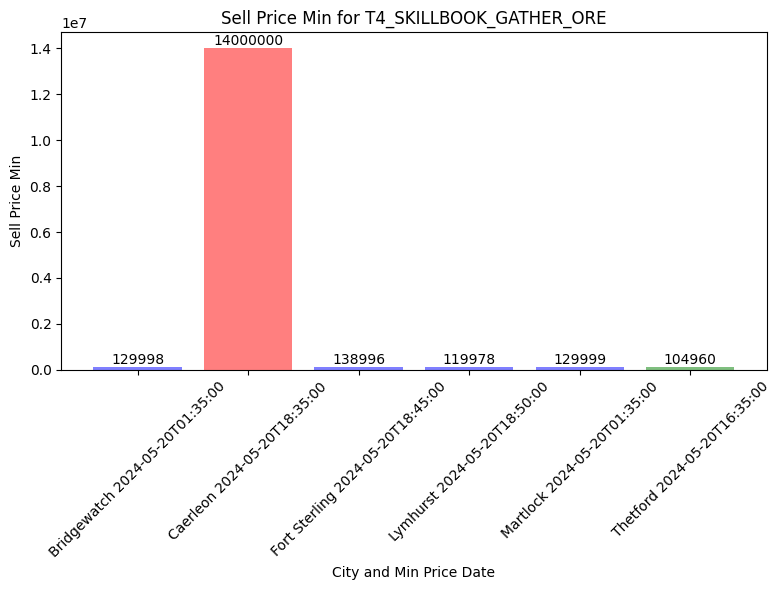

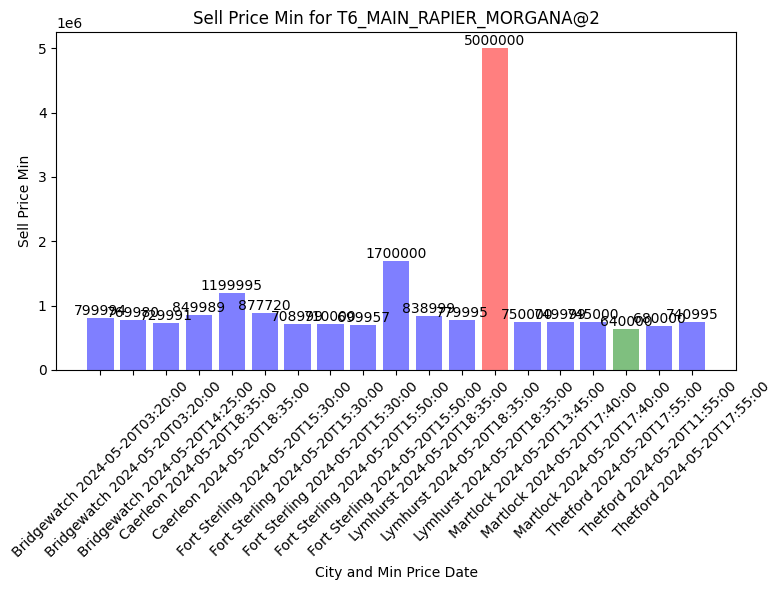

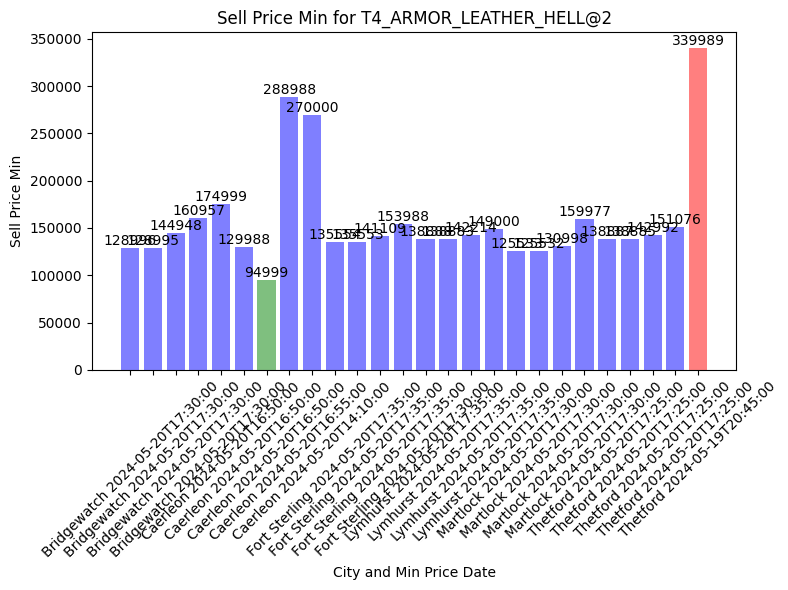

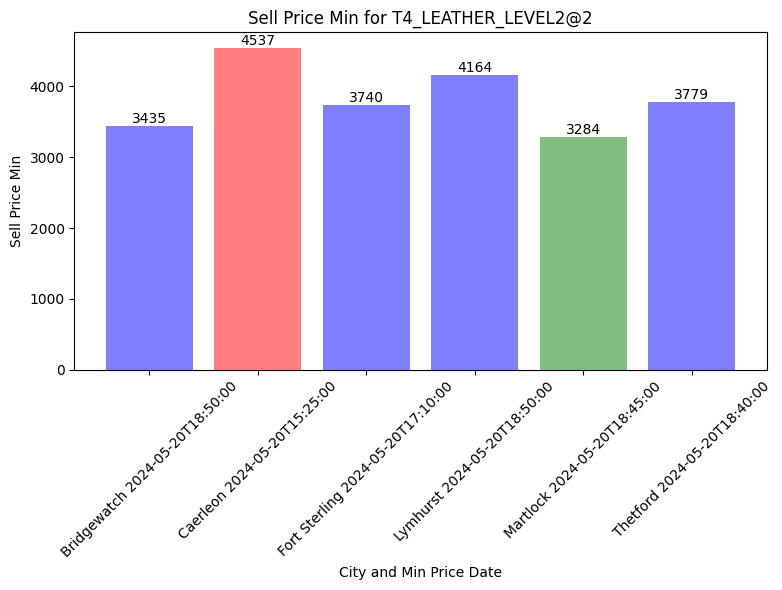

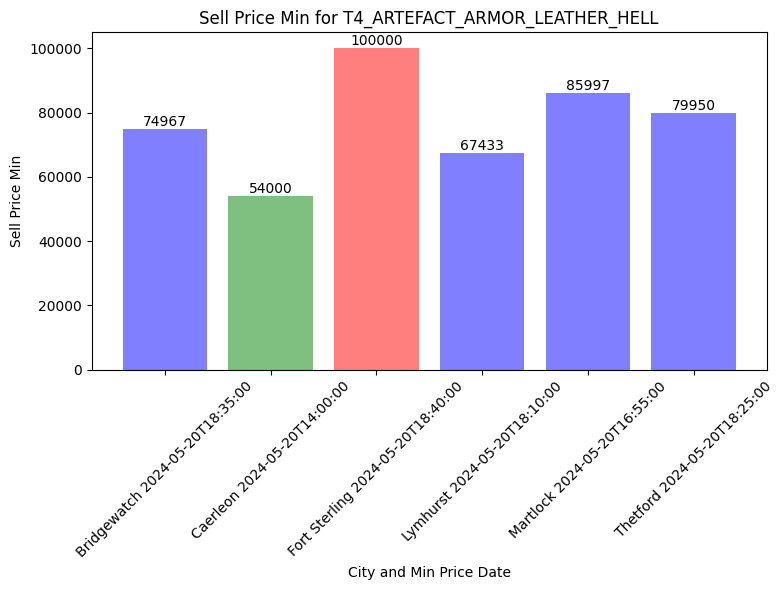

In [1]:
import pip._vendor.requests
import datetime

import mysql.connector
import json

from collections import defaultdict

import matplotlib.pyplot as plt


def get_request(item):
    
    url = 'https://europe.albion-online-data.com/api/v2/stats/prices/%s.json?locations=Thetford, Fort Sterling, Lymhurst, Martlock, Bridgewatch, Caerleon&qualities=0' %(item)
    params = {'key1': 'value1', 'key2': 'value2'}  # Optional parameters
    
    try:
        response = pip._vendor.requests.get(url, params=params)
        response.raise_for_status()  # Raise an HTTPError for bad responses
        return response.json()  # Assuming the response is in JSON format
    except pip._vendor.requests.exceptions.HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')

# Read contents of the file
with open('items_config.txt', 'r') as file:
    file_contents = file.read()

# Split the content into individual items
items_config_list = file_contents.split(',')

# Remove leading and trailing whitespace from each item
items_config_list = [item.strip() for item in items_config_list]

# Convert the list to a tuple
items_config = tuple(items_config_list)

def main():

    updated_date = datetime.datetime.now().replace(microsecond=0).isoformat()
    json_data = []

    for item in items_config:
        data = get_request(item)
        if data:
            json_data += data

    # Database connection
    db = mysql.connector.connect(
        host="localhost",
        user="root",
        password="val094256",
        database="albion"
    )

    cursor = db.cursor()

    # Insert query
    insert_query = """
    INSERT IGNORE INTO current_data (
        item_id, city, quality, sell_price_min, sell_price_min_date, 
        sell_price_max, sell_price_max_date, buy_price_min, buy_price_min_date, 
        buy_price_max, buy_price_max_date, updated_date
    ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """

    try:
        # List to hold all the values to be inserted
        all_values = []
        
        # Extract values from JSON data
        for item in json_data:
            
            if item["sell_price_min"] == 0 and item["sell_price_max"] == 0 and item["buy_price_max"] == 0 :
                    continue
            
            values = (
                item["item_id"],
                item["city"],
                item["quality"],
                item["sell_price_min"],
                item["sell_price_min_date"],
                item["sell_price_max"],
                item["sell_price_max_date"],
                item["buy_price_min"],
                item["buy_price_min_date"],
                item["buy_price_max"],
                item["buy_price_max_date"],
                updated_date
            )
            all_values.append(values)
        
        # Execute the insert query with IGNORE for each record
        cursor.executemany(insert_query, all_values)        
        
        # Commit the transaction
        db.commit()
        
        print(f"Data inserted successfully at: ", updated_date)
    except mysql.connector.Error as err:
        # Rollback in case of an error
        db.rollback()
        print(f"Error: {err}")
    finally:
        # Close the cursor and connection
        cursor.close()
        db.close()

    # Organize data by item_id and select the latest sell price for each city
    item_sell_prices = defaultdict(list)
    for item in json_data:
        item_id = item["item_id"]
        city = item["city"]
        sell_price = item["sell_price_min"]
        sell_date = item["sell_price_min_date"]
        if sell_price != 0:
            item_sell_prices[item_id].append((city, sell_price, sell_date))

    # Create bar chart for each item_id
    for item_id, data in item_sell_prices.items():
        labels = [f'{city} {date}' for city, _, date in data]
        sell_prices = [sell_price for _, sell_price, _ in data]

        # Find highest and lowest sell prices
        max_price = max(sell_prices)
        min_price = min(sell_prices)

        # Determine bar colors
        colors = ['red' if price == max_price else 'green' if price == min_price else 'blue' for price in sell_prices]

        plt.figure(figsize=(8, 6))
        bars = plt.bar(range(len(labels)), sell_prices, align='center', alpha=0.5, color=colors)
        plt.xticks(range(len(labels)), labels, rotation=45)
        plt.xlabel('City and Min Price Date')
        plt.ylabel('Sell Price Min')
        plt.title(f'Sell Price Min for {item_id}')
        plt.tight_layout()

        # Add price values on top of the bars
        for bar, price in zip(bars, sell_prices):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{price}', ha='center', va='bottom')

        plt.show()


main()





In [1]:
from datetime import datetime
from collections import defaultdict

import matplotlib.pyplot as plt

# Organize data by item_id and select the latest sell price for each city
item_sell_prices = defaultdict(list)
for item in json_data:
    item_id = item["item_id"]
    city = item["city"]
    sell_price = item["sell_price_min"]
    sell_date = item["sell_price_min_date"]
    if sell_price != 0:
        item_sell_prices[item_id].append((city, sell_price, sell_date))

# Create bar chart for each item_id
for item_id, data in item_sell_prices.items():
    labels = [f'{city}' for city, _, date in data]
    sell_prices = [sell_price for _, sell_price, _ in data]

    # Find highest and lowest sell prices
    max_price = max(sell_prices)
    min_price = min(sell_prices)

    # Determine bar colors
    colors = ['red' if price == max_price else 'green' if price == min_price else 'blue' for price in sell_prices]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(range(len(labels)), sell_prices, align='center', alpha=0.5, color=colors)
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.xlabel('City and Min Price Date')
    plt.ylabel('Sell Price Min')
    plt.title(f'Sell Price Min for {item_id}')
    plt.tight_layout()

    # Add price values on top of the bars
    for bar, price in zip(bars, sell_prices):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{price}', ha='center', va='bottom')

    plt.show()


NameError: name 'json_data' is not defined